# Unsupervised Learning of Edge Orientation Detection with Brian2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
from brian2tools import brian_plot, plot_state
from TacNet import TacNet
from TouchDataset import TouchDataset

set_device("cpp_standalone")


def wrap2pi(angles):
    theta = np.array(angles)
    theta = theta.reshape(-1)
    n = np.floor(theta / np.pi)
    return theta - n * np.pi


# Prepare dataset
n = 10
dataset = TouchDataset("../data/touch.pkl", flatten=False)
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.7)
data, orientations = np.repeat(X_train, n, axis=0), np.repeat(y_train, n, axis=0)

# Convert values to spikes
dt = 1 * ms
length, height, width = data.shape
inputs = data.reshape(length, -1)
inputs[inputs > 0] = 1.0
I = TimedArray(inputs * 200 * pA, dt=dt)

# Prepare simulation
duration = I.values.shape[0] * dt
num_neurons = [height * width, 25, 36]
model = TacNet(num_neurons)
mons = model.run(I, duration)

# Plot results
fig, axs = plt.subplots(8, 1, figsize=(20, 21))
for i in range(3):
    axs[i].set_title("Spike L" + str(i + 1))
    brian_plot(mons["SpikeMonitor_L" + str(i + 1)], axes=axs[i])

axs[3].set_title("L3 Membrane Potential")
plot_state(mons["StateMonitor_L3"].t, mons["StateMonitor_L3"].v.T, axes=axs[3])
axs[4].set_title("Syn23 X")
plot_state(mons["StateMonitor_Syn23"].t, mons["StateMonitor_Syn23"].X.T, axes=axs[4])
axs[5].set_title("Syn12 Connectivity")
brian_plot(model.net["Syn12"], axes=axs[5])
axs[6].set_title("Syn23 Final X")
axs[6].set_xlabel("target neuron index")
axs[6].set_ylabel("source neuron index")
axs[6].imshow(model.net["Syn23"].X_[:].reshape((num_neurons[1], num_neurons[2])))
axs[7].plot(wrap2pi(orientations))
axs[7].set_title("Rotation Angles")
axs[7].set_xlabel("time (ms)")
axs[7].set_ylabel("rad")
plt.tight_layout()
plt.show()

INFO:root:creating /tmp/brian_flag_test_2hq8i2ox/tmp
INFO:root:creating /tmp/brian_flag_test_2hq8i2ox/tmp/brian_flag_test_2hq8i2ox
INFO:root:/home/alex/miniconda3/envs/tac3d/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/alex/miniconda3/envs/tac3d/include -fPIC -O2 -isystem /home/alex/miniconda3/envs/tac3d/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/alex/miniconda3/envs/tac3d/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/alex/miniconda3/envs/tac3d/include -fPIC -c /tmp/brian_flag_test_2hq8i2ox/flag_test.cpp -o /tmp/brian_flag_test_2hq8i2ox/tmp/brian_flag_test_2hq8i2ox/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test__wp9emqe/tmp
INFO:root:creating /tmp/brian_flag_test__wp9emqe/tmp/brian_flag_test__wp9emqe
INFO:root:/home/alex/miniconda3/envs/tac3d/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compar

# Generative MGGD Spatial Model

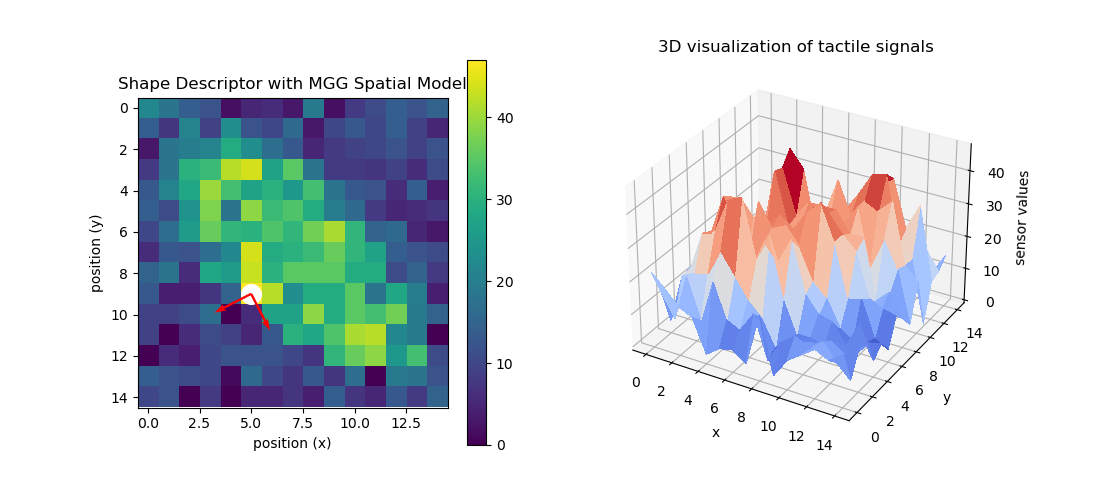

In [25]:
%matplotlib widget
from random import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from numpy import linalg as LA


def genScatter():
    alpha = random() * 2 * np.pi
    beta = alpha + np.pi / 2.0

    Q = np.array([[np.cos(alpha), np.cos(beta)], [np.sin(alpha), np.sin(beta)]])
    P = np.diag(np.random.rand(2))
    M = np.matmul(np.matmul(Q, P), LA.inv(Q))

    return M * p / M.trace()


def normalize2(xs, scope):
    xs = (xs - xs.min()) / (xs.max() - xs.min())
    return np.round(xs * (scope - 1))


# MGGD stochastic parameters
beta = np.random.rand(1) * 15
p = 2  # dimensionality
m = np.random.rand(1) * 15
nsamples = 2000
M = genScatter()

# Stochastic process
Sigma = np.sqrt(np.abs(m * M))
phi = 2 * np.pi * np.random.random(nsamples) - np.pi
u = np.array([np.cos(phi), np.sin(phi)])
tau = np.power(np.random.gamma(0.5 * p / beta, 2, nsamples), 0.5 / beta)
x = tau * np.matmul(Sigma, u)

x = normalize2(x, 15)

im = np.zeros((15, 15), dtype=int)
for ns in np.arange(nsamples):
    i, j = (
        np.round(x[0, ns]).astype(int),
        np.round(x[1, ns]).astype(int),
    )
    im[i, j] += 1
noise = np.random.normal(np.mean(im), 0.5 * np.sqrt(np.var(im)), im.shape)
im += np.round(noise).astype(int)
im[im < 0] = 0
center = np.argwhere(im == im.max())[0]
w, v = LA.eig(M)
X = [center[1], center[1]]
Y = [center[0], center[0]]
U = v[0, :]
V = v[1, :]
scale = np.abs(w)

fig = plt.figure(figsize=(11, 5))

ax = fig.add_subplot(1, 2, 1)
image = ax.imshow(im)
ax.scatter(center[1], center[0], s=200, c="w")
ax.quiver(
    [center[1], center[1]],
    [center[0], center[0]],
    v[0, :],
    v[1, :],
    color="r",
    scale_units="xy",
    scale=0.5,
)
ax.set_aspect("equal", "box")
ax.set_title("Shape Descriptor with MGG Spatial Model")
ax.set_xlabel("position (x)")
ax.set_ylabel("position (y)")
fig.colorbar(image, ax=ax)

ax = fig.add_subplot(1, 2, 2, projection="3d")
X = np.arange(0, 15, 1)
Y = np.arange(0, 15, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, im, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_title("3D visualization of tactile signals")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("sensor values")

plt.show()

# Tactile Encoder with Nengo

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Train/test error: 0.03, 0.05


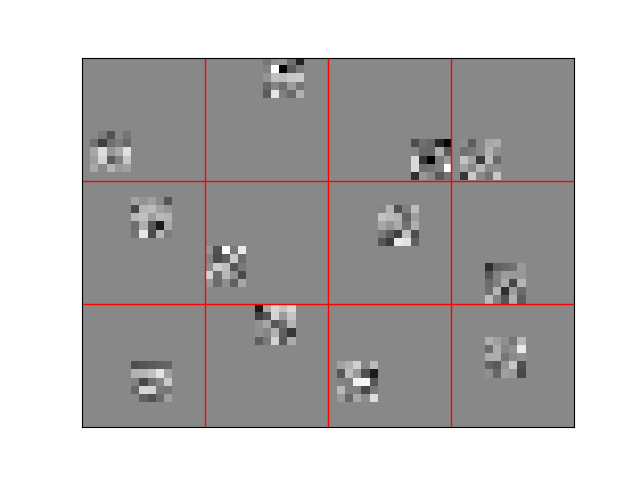

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import nengo
import numpy as np
from nengo_extras.data import load_mnist, one_hot_from_labels
from nengo_extras.matplotlib import tile
from nengo_extras.vision import Gabor, Mask
from TouchDataset import TouchDataset

rng = np.random.RandomState(9)

nRows, nCols = 15, 15

# prepare dataset
dataset = TouchDataset("../data/touch.pkl", flatten=True, normalize=(-1, 1))
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.3)

T_train = y_train

# set up network parameters
n_vis = X_train.shape[1]
n_out = T_train.shape[1]

# number of hidden units
# More means better performance but longer training time.
n_hid = 1000

ens_params = dict(
    eval_points=X_train,
    neuron_type=nengo.LIFRate(),
    intercepts=nengo.dists.Choice([0.1]),
    max_rates=nengo.dists.Choice([200]),
)

solver = nengo.solvers.LstsqL2(reg=1e-2)

with nengo.Network(seed=1024) as model:
    a = nengo.Ensemble(n_neurons=n_hid, dimensions=n_vis, **ens_params)
    v = nengo.Node(size_in=n_out)
    conn = nengo.Connection(
        a, v, synapse=None, eval_points=X_train, function=T_train, solver=solver
    )


def get_outs(simulator, images):
    # encode the images to get the ensemble activations
    _, acts = nengo.utils.ensemble.tuning_curves(a, simulator, inputs=images)

    # decode the ensemble activities using the connection's decoders
    return np.dot(acts, simulator.data[conn].weights.T)


def get_error(simulator, images, labels):
    return np.sqrt(np.sum(np.square(get_outs(simulator, images) - labels)))


def print_error(simulator):
    train_error = get_error(simulator, X_train, y_train) / len(X_train)
    test_error = get_error(simulator, X_test, y_test) / len(X_test)
    print("Train/test error: %.2f, %.2f" % (train_error, test_error))


encoders = rng.normal(size=(n_hid, 5, 5))
encoders = Mask((nRows, nCols)).populate(encoders, rng=rng, flatten=True)
a.encoders = encoders

tile(encoders.reshape((-1, nRows, nCols)), rows=3, cols=4, grid=True)

with nengo.Simulator(model) as sim:
    print_error(sim)